## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.read_csv('ETTh2.csv')
df.head(10)

,Date,OT
0,7/1/2016 0:00,38.661999
1,7/1/2016 1:00,37.124001
2,7/1/2016 2:00,36.465000
3,7/1/2016 3:00,33.608501
4,7/1/2016 4:00,31.850500
5,7/1/2016 5:00,30.532000
6,7/1/2016 6:00,30.093000
7,7/1/2016 7:00,29.872999
8,7/1/2016 8:00,29.653000
9,7/1/2016 9:00,29.213499


In [2]:
# Converting the dt column to datetime object 
df['Date'] = [pd.to_datetime(x) for x in df['Date']]
df.head(10)

,Date,OT
0,2016-07-01 00:00:00,38.661999
1,2016-07-01 01:00:00,37.124001
2,2016-07-01 02:00:00,36.465000
3,2016-07-01 03:00:00,33.608501
4,2016-07-01 04:00:00,31.850500
5,2016-07-01 05:00:00,30.532000
6,2016-07-01 06:00:00,30.093000
7,2016-07-01 07:00:00,29.872999
8,2016-07-01 08:00:00,29.653000
9,2016-07-01 09:00:00,29.213499


In [3]:
df = df.sort_values('Date')
df.head(10)

,Date,OT
0,2016-07-01 00:00:00,38.661999
1,2016-07-01 01:00:00,37.124001
2,2016-07-01 02:00:00,36.465000
3,2016-07-01 03:00:00,33.608501
4,2016-07-01 04:00:00,31.850500
5,2016-07-01 05:00:00,30.532000
6,2016-07-01 06:00:00,30.093000
7,2016-07-01 07:00:00,29.872999
8,2016-07-01 08:00:00,29.653000
9,2016-07-01 09:00:00,29.213499


## Prepare data

In [4]:
INPUT_SIZE = 48 # Dùng `input_size` giờ trước
LABEL_SIZE = 12  # Để dự đoán nhiệt độ trong `label_size` giờ
BATCH_SIZE = 32
FEATURE_FINAL = ['OT']
label_name = 'OT'

In [5]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, label_name):
    features = [] # Khai báo list dùng để lưu trữ các X
    labels = []   # Khai báo list dùng để lưu trữ các y

    window_size = input_size + label_size # Tính kích thước của window

    # Nếu df_end_idx = chỉ mục cuối cùng bảng dữ liệu, cần phải dời xuống 1 khoảng = window size 
    if df_end_idx == None:
        df_end_idx = len(df) - window_size 
    
    # Duyệt qua từng mẫu dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # Tính chỉ mục kết thúc của X
        label_start_idx = idx + window_size - label_size # Tính chỉ mục bắt đầu của y

        feature = df[idx:feature_end_idx] # Lấy X
        label = df[label_name][label_start_idx:(idx+window_size)] # Lấy y

        features.append(feature) 
        labels.append(label)

    # Chuyển list thành np.ndarrray
    features = np.array(features)
    print(features.shape)
    labels = np.array(labels)

    return features, labels

In [6]:
dataset_length = len(df) # Số lượng mẫu dữ liệu trong DataFrame
TRAIN_SIZE = 0.8         # Tỉ lệ kích thước tập train
VAL_SIZE = 0.1           # Tỉ lệ kích thước tập val

# Đổi tỉ lệ thành chỉ mục
TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length) 
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX
df = df[FEATURE_FINAL]

# Khởi tạo X, y cho tập train
X_train, y_train = slicing_window(df, 
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  label_name = label_name)

# Khởi tạo X, y cho tập val
X_val, y_val = slicing_window(df, 
                              df_start_idx=TRAIN_END_IDX,
                              df_end_idx=VAL_END_IDX,
                              input_size=INPUT_SIZE,
                              label_size=LABEL_SIZE,
                              label_name = label_name)

# Khởi tạo X, y cho tập test
X_test, y_test = slicing_window(df, 
                                df_start_idx=VAL_END_IDX,
                                df_end_idx=None,
                                input_size=INPUT_SIZE,
                                label_size=LABEL_SIZE,
                                label_name = label_name)

(13936, 48, 1)
(1742, 48, 1)
(1682, 48, 1)


In [7]:
print(X_train.shape)
print(y_train.shape)

(13936, 48, 1)
(13936, 12)


In [8]:
import tensorflow as tf

# Khởi tạo tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

# Cấu hình các tham số tối ưu cho việc đọc dữ liệu
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model and train

In [9]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(axis=-1)
normalize_layer.adapt(np.vstack((X_train, X_val, X_test)))

In [10]:
input_shape = X_train.shape[-2:]
model = tf.keras.Sequential([tf.keras.Input(shape=input_shape, name='input_layer'), 
                             normalize_layer,  
                             tf.keras.layers.LSTM(32, return_sequences=True), 
                             tf.keras.layers.LSTM(32), 
                             tf.keras.layers.Dense(16),
                             tf.keras.layers.Dense(LABEL_SIZE)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 48, 1)            3         
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 48, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 12)                204       
                                                                 
Total params: 13,407
Trainable params: 13,404
Non-trainable params: 3
____________________________________________________

In [11]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 30
LR = 1e-3

# Cấu hình một số thông tin cho mô hình
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/30
436/436 [==============================] - 128s 176ms/step - loss: 11.1082 - val_loss: 6.9427
Epoch 2/30
436/436 [==============================] - 56s 129ms/step - loss: 6.1148 - val_loss: 6.9862
Epoch 3/30
436/436 [==============================] - 65s 148ms/step - loss: 5.3060 - val_loss: 6.6588
Epoch 4/30
436/436 [==============================] - 66s 152ms/step - loss: 5.0225 - val_loss: 6.2578
Epoch 5/30
436/436 [==============================] - 63s 143ms/step - loss: 4.4626 - val_loss: 5.9869
Epoch 6/30
436/436 [==============================] - 58s 133ms/step - loss: 4.2324 - val_loss: 5.4117
Epoch 7/30
278/436 [==================>...........] - ETA: 20s - loss: 4.1295

In [ ]:
# Đánh giá mô hình trên tập test
test_evaluation = model.evaluate(test_ds)

53/53 [==============================] - 0s 1ms/step - loss: 3.8853


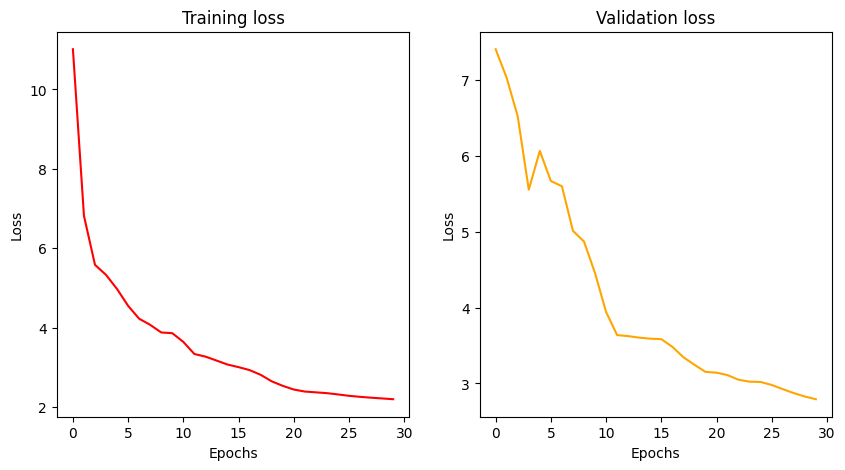

In [ ]:
train_loss = history.history['loss']# Đọc thông tin loss trên tập train
val_loss = history.history['val_loss'] # Đọc thông tin loss trên tập val

plt.figure(figsize=(10, 5)) # Cài đặt kích thước khung ảnh

plt.subplot(1, 2, 1) # Khởi tạo khung ảnh cho training loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Training loss') # Hiển thị title của khung ảnh hiện tại là 'Training Loss'
plt.plot(train_loss, color='red') # Vẽ đường giá trị loss trên tập train qua từng epoch (đường vẽ màu đỏ)

plt.subplot(1, 2, 2) # Khởi tạo khung ảnh cho val loss
plt.xlabel('Epochs') # Hiển thị tên trục hoành là 'Epochs'
plt.ylabel('Loss') # Hiển thị tên trục tung là 'Loss'
plt.title('Validation loss') # Hiển thị title của khung ảnh hiện tại là 'Validation loss'
plt.plot(val_loss, color='orange') # Vẽ đường giá trị loss trên tập val qua từng epoch (đường vẽ màu đỏ)

plt.show() # Hiển thị 2 khung ảnh nhỏ